In [168]:
'''
Author: Tyler Chin

References (helped massively): https://www.youtube.com/watch?v=q_HS4s1L8UI&t=1768s

A script that enables the discord bot to predict stocks!
'''

'\nAuthor: Tyler Chin\n\nReferences (helped massively): https://www.youtube.com/watch?v=q_HS4s1L8UI&t=1768s\n\nA script that enables the discord bot to predict stocks!\n'

In [169]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf
import random

from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [170]:
'''
Constants that are used throughtout the script
'''
#data prep
peer_into = 13 # 1 <= n <= days the stocks existed
training_split = 0.95 # 0 < n < 1

# Datasets
test_size = 16

#trainin
epochs = 10 # 0 < n < infinity
lr = 0.1
loss_function = nn.MSELoss()

In [171]:
def data_processor(peer_into: int, df) -> None:
    '''
    Prepares the data to be read by LSTM

    Creates <peer_into> new rows of data which shift each row down by one
    '''
    for i in range(1, peer_into): 
        df[f'Open (t-{i})'] = df['Open'].shift(i) # Loops to shift in each items into place

    df.dropna(inplace=True) # drop all values with nan because those are not helpful for the LSTM

In [172]:
btc = yf.Ticker('BTC-USD')
data = btc.history(period='max')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [173]:
data = data.drop(['Close', 'Volume','High','Low', 'Dividends', 'Stock Splits'], axis=1)
data_processor(peer_into, data)
np_data = data.to_numpy()
data

,Open,Open (t-1),Open (t-2),Open (t-3),Open (t-4),Open (t-5),Open (t-6),Open (t-7),Open (t-8),Open (t-9),Open (t-10),Open (t-11),Open (t-12)
Date,,,,,,,,,,,,,
2014-09-29 00:00:00+00:00,376.928009,399.471008,403.556000,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991,394.673004,424.102997,456.859985,465.864014
2014-09-30 00:00:00+00:00,376.088013,376.928009,399.471008,403.556000,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991,394.673004,424.102997,456.859985
2014-10-01 00:00:00+00:00,387.427002,376.088013,376.928009,399.471008,403.556000,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991,394.673004,424.102997
2014-10-02 00:00:00+00:00,383.988007,387.427002,376.088013,376.928009,399.471008,403.556000,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991,394.673004
2014-10-03 00:00:00+00:00,375.181000,383.988007,387.427002,376.088013,376.928009,399.471008,403.556000,411.428986,423.156006,435.751007,402.092010,399.100006,408.084991
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-17 00:00:00+00:00,117492.789062,117398.421875,118365.781250,123339.398438,120168.976562,118717.664062,119306.812500,116497.718750,116678.273438,117505.500000,115030.054688,114140.914062,115072.187500
2025-08-18 00:00:00+00:00,117453.906250,117492.789062,117398.421875,118365.781250,123339.398438,120168.976562,118717.664062,119306.812500,116497.718750,116678.273438,117505.500000,115030.054688,114140.914062
2025-08-19 00:00:00+00:00,116241.859375,117453.906250,117492.789062,117398.421875,118365.781250,123339.398438,120168.976562,118717.664062,119306.812500,116497.718750,116678.273438,117505.500000,115030.054688


In [174]:
scaler = MinMaxScaler((-1, 1))
data = scaler.fit_transform(data)
data

array([[-0.99675175, -0.99638569, -0.99631935, ..., -0.99587373,
        -0.99532696, -0.99517667],
       [-0.9967654 , -0.99675175, -0.99638569, ..., -0.99636496,
        -0.99587373, -0.99532696],
       [-0.99658126, -0.9967654 , -0.99675175, ..., -0.9961411 ,
        -0.99636496, -0.99587373],
       ...,
       [ 0.88474513,  0.90442721,  0.90505861, ...,  0.94459762,
         0.95840538,  0.91708616],
       [ 0.82930884,  0.88474513,  0.90442721, ...,  0.94158387,
         0.94459762,  0.95840538],
       [ 0.85271631,  0.82930884,  0.88474513, ...,  0.98847221,
         0.94158387,  0.94459762]], shape=(3980, 13))

In [175]:
X = data[:, 1:]
X = np.flip(X, axis=1)
Y = data[:, 0]

split = int(len(X) * training_split)

X_train = np.array(np.empty(12))
Y_train = np.array([])

X_test = np.array(np.empty(12))
Y_test = np.array([])
for i in range(len(X)): # randomizes the data a bit
    seed = random.randint(0, len(X))

    if split >= seed:
        X_train = np.vstack([X_train, X[i]])
        Y_train = np.append(Y_train, Y[i])
        continue
    
    X_test = np.vstack([X_test, X[i]])
    Y_test = np.append(Y_test, Y[i])

X_train.shape, Y_train

((3778, 12),
 array([-0.99675175, -0.9967654 , -0.99658126, ...,  0.88474513,
         0.82930884,  0.85271631], shape=(3777,)))

In [176]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


Y_train = Y_train.reshape((-1, 1))
Y_test = Y_test.reshape((-1, 1))

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3778, 12, 1), (3777, 1), (204, 12, 1), (203, 1))

In [177]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()
X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([3778, 12, 1]),
 torch.Size([3777, 1]),
 torch.Size([204, 12, 1]),
 torch.Size([203, 1]))

In [178]:
class BTCDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X) - 1

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [179]:
training_dataset = BTCDataset(X_train, Y_train)
testing_dataset = BTCDataset(X_test, Y_test)

train_loader = DataLoader(training_dataset, batch_size=test_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=test_size, shuffle=False)

In [180]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 12, 1]) torch.Size([16, 1])


In [181]:
class LSTM(nn.Module):
    def __init__(self, input, hidden, layers):
        super().__init__()
        self.hidden = hidden
        self.layers = layers
        self.lstm = nn.LSTM(input, hidden, layers, batch_first=True)
        self.fc = nn.Linear(hidden, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.layers, batch_size, self.hidden).to(device)
        c0 = torch.zeros(self.layers, batch_size, self.hidden).to(device)
        output, _ = self.lstm(x, (h0, c0))
        output = self.fc(output[:, -1, :])
        return output
    
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [182]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch {e + 1}')
    overall_loss = 0.0

    for i, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        overall_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 99:
            avg_loss_across_batches = overall_loss / 100
            print(f'Batch {i}, Loss: {avg_loss_across_batches}')

In [183]:
def validate_one_epoch():
    model.train(False)
    overall_loss = 0.0

    for i, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            overall_loss += loss.item()

        avg_loss_across_batches = overall_loss / len(test_loader)

        print(f'Val Loss: {avg_loss_across_batches}')

In [184]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for e in range(epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch 1
Batch 99, Loss: 0.010434511986750295
Batch 199, Loss: 0.011616362222630414
Val Loss: 0.006439143648514381
Val Loss: 0.006487184687732504
Val Loss: 0.006535874303573599
Val Loss: 0.006774419452995062
Val Loss: 0.0068107182831646735
Val Loss: 0.00688381686520118
Val Loss: 0.008203168542912373
Val Loss: 0.010953770162394414
Val Loss: 0.012133683364551801
Val Loss: 0.012320528218809228
Val Loss: 0.013427192255711326
Val Loss: 0.01570439415697295
Val Loss: 0.01956951036117971
Epoch 2
Batch 99, Loss: 0.002574182558892062
Batch 199, Loss: 0.004954150534940709
Val Loss: 0.005144911316724924
Val Loss: 0.005151774535009351
Val Loss: 0.005159535629410619
Val Loss: 0.005340433003976404
Val Loss: 0.005360772992739489
Val Loss: 0.005418738765001763
Val Loss: 0.006766443340613757
Val Loss: 0.008201506260285476
Val Loss: 0.008866312182083046
Val Loss: 0.008999650432087947
Val Loss: 0.009787744764672915
Val Loss: 0.010901146132360177
Val Loss: 0.012291965068680629
Epoch 3
Batch 99, Loss: 0.0017

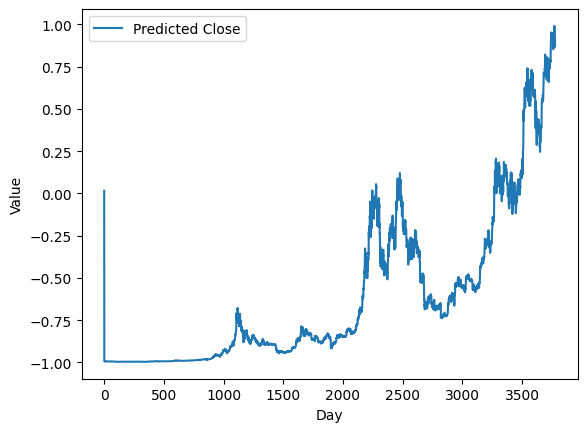

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(Y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()